In [1]:
import torch
from torch import nn

In [2]:
import torch.nn.functional as F
import math

In [3]:
from d2l_common import Module


class RNNScratch(Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens)*sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens)*sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, x, state=None):
        if state is None:
            state = torch.zeros(
                (x.shape[1], self.num_hiddens), device=x.device)
        else:
            state, = state
        outputs = []
        for X in x:
            # [batch_size, num_inputs]
            state = torch.tanh(X@self.W_xh+state@self.W_hh+self.b_h)
            outputs.append(state)
        return outputs, state
    
    
    

In [4]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
inputs = torch.ones((num_steps, batch_size, num_inputs))
inputs.shape

outputs, state = rnn.forward(inputs)

In [5]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'
            
check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [12]:
from d2l_common import Classifier
import matplotlib.pyplot as plt


class RNNLMScratch(Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.rnn = rnn
        self.lr = lr
        self.vocab_size = vocab_size
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(torch.randn(
            self.rnn.num_hiddens, self.vocab_size)*self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def train_step(self, batch):
        y_hat, y = self(*batch[:-1]), F.one_hot(batch[-1],
                                                self.vocab_size).type(torch.float32)
        l = self.loss(y_hat, y)
        return l

    def validate_step(self, batch):
        y_hat, y = self(*batch[:-1]), F.one_hot(batch[-1],
                                                self.vocab_size).type(torch.float32)
        l = self.loss(y_hat, y)
        return y_hat, l

    def accuracy(self, y_hat, y, averaged=True):
        cmp = (y_hat == F.one_hot(y, self.vocab_size).type(
            torch.float32)).type(torch.float32)
        return cmp.mean() if averaged else cmp

    def one_hot(self, x):
        return F.one_hot(x.T, self.vocab_size).type(torch.float32)

    def output_layer(self, rnn_outputs):
        outputs = [H@self.W_hq for H in rnn_outputs]
        return torch.stack(outputs, dim=1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)  # [num_steps, batch_size, vocab_size]
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)

    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix)+num_preds-1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix)-1:
                outputs.append(vocab[prefix[i+1]])
            else:
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(dim=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [13]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [14]:
torch.stack([torch.ones(3,1),torch.ones(3,1)],dim=1).shape

torch.Size([3, 2, 1])

In [15]:
print(batch_size, num_inputs, num_hiddens,num_steps)
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
print(outputs.shape)
check_shape(outputs, (batch_size, num_steps, num_inputs))

2 16 32 100


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x16 and 28x32)

In [16]:
from d2l_common import TimeMachine, Trainer

data = TimeMachine(batch_size=1024, num_steps=32)
# for x in data.get_dataloader(train=True):
#     print(x[0].shape,x[1].shape)
#     print(*x[0])
#     print(*x[1])
#     print(*x[:-1])
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = Trainer(max_epochs=100, gradient_clip_val=1)
trainer.fit(model, data)

complete 0 epoch train_loss=3.9608867168426514 validate_loss=3.960679292678833
complete 1 epoch train_loss=3.960679292678833 validate_loss=3.9604716300964355
complete 2 epoch train_loss=3.9604716300964355 validate_loss=3.9602580070495605
complete 3 epoch train_loss=3.9602580070495605 validate_loss=3.9600329399108887
complete 4 epoch train_loss=3.9600329399108887 validate_loss=3.9597907066345215
complete 5 epoch train_loss=3.9597907066345215 validate_loss=3.959524393081665
complete 6 epoch train_loss=3.959524393081665 validate_loss=3.9592268466949463
complete 7 epoch train_loss=3.9592268466949463 validate_loss=3.9588894844055176
complete 8 epoch train_loss=3.9588894844055176 validate_loss=3.9585037231445312
complete 9 epoch train_loss=3.9585037231445312 validate_loss=3.9580578804016113
complete 10 epoch train_loss=3.9580578804016113 validate_loss=3.9575388431549072
complete 11 epoch train_loss=3.9575388431549072 validate_loss=3.9569320678710938
complete 12 epoch train_loss=3.95693206787

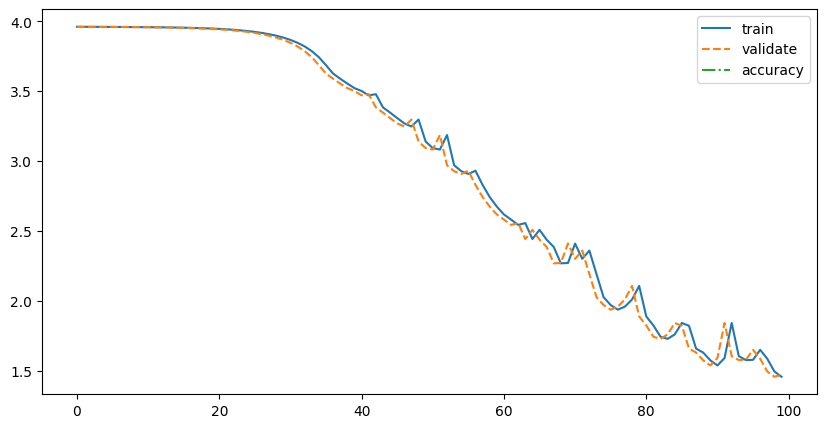

In [17]:
trainer.plot()

In [18]:
model.predict('it has', 20, data.vocab)

'it hasenbergject gutenberg'